# Оценка результатов проведения А/В тестирования данных пользователей ленты новостей

У нас параллельно идут два теста, оба – с  2022-12-02 по 2022-12-08 включительно

Первый:
* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"


Второй:
* exp_group = 0 – Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"

Мы будем оценивать *первый* А/В тест.  
Для эксперимента были задействованы 2 и 1 группы.  

**Основная гипотеза** - новый алгоритм во 2-й группе приведет к увеличению CTR.  

**Наша задача** — проанализировать данные первого АB-теста, который проводился на 1 и 2 группах. 


## Загрузка данных

Загружаем необходимые библиотеки:

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm

%matplotlib inline

Подключаемся к базе данных clickhouse:

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Делаем SQL  запрос к базе данных ленты новостей и отбираем данные с '2022-12-02' по '2022-12-08' для 1 и 2 экспериментальных групп:

In [3]:

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


Проверяем, равны ли группы по числу пользователей - должны быть : более-менее равны

In [4]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Всё ОК! Группы получились примерно более-менее равны.

Поделим на две группы:

In [5]:
group_1 = df[df.exp_group == 1]
group_2 = df[df.exp_group == 2]

Первую группу посмотрим глазами, а именно распределение CTR:

<AxesSubplot:xlabel='ctr', ylabel='Count'>

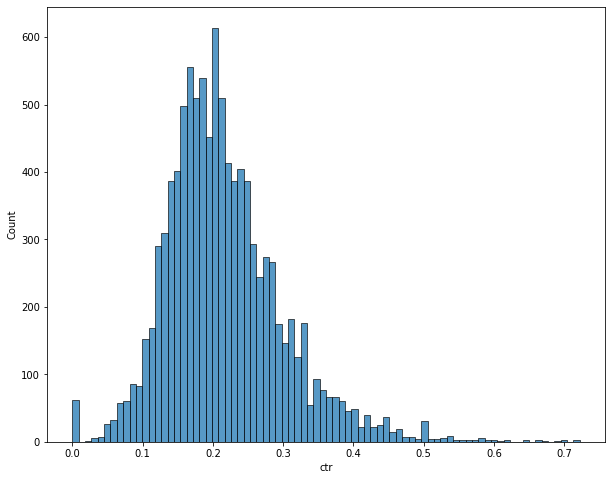

In [6]:
plt.figure(figsize=(10, 8))
sns.histplot(data = group_1, x='ctr')

Распределение данных CTR для первой группы вроде выглядит нормальным.  

Теперь посмотрим распределение CTR для второй группы: 

<AxesSubplot:xlabel='ctr', ylabel='Count'>

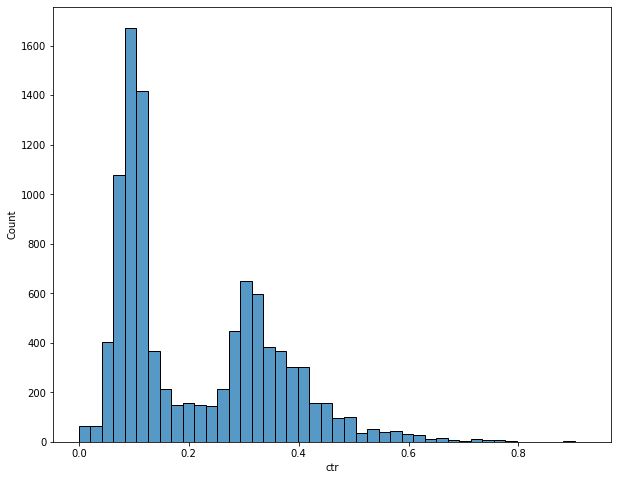

In [7]:
plt.figure(figsize=(10, 8))
sns.histplot(data = group_2, x='ctr')

У второй группы распределение совсем далеко от нормального.  
Посмотрим распределение CTR для двух групп на одном графике:

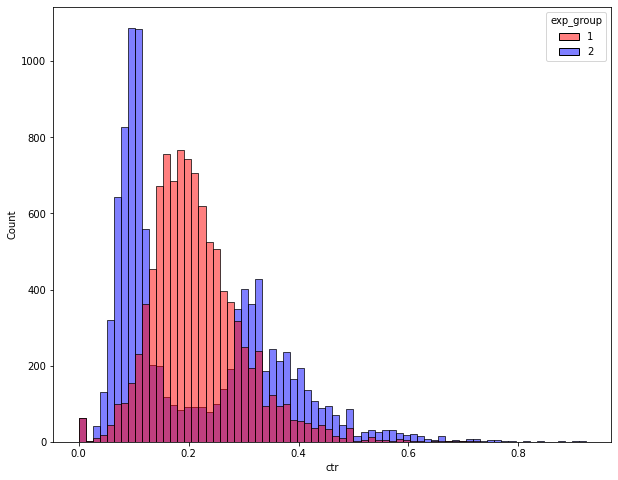

In [8]:
# на одном графике - визуально сильно отличаются друг от друга - но какое лучше?
plt.figure(figsize=(10, 8))
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Визуально мы видим что, CTR  двух групп отличаются. В таком случае сравним данные тестами.

### Сравнение результатов А/В тестирования с помощью тестов: T-критерий и Манна-Уитни

**T- критерий:** 

In [9]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

**Вывод:**  
T-test показал, что нет статистически значимых различий.  
Возможно, тест не сработалв связи с тем, что распределение 2-ой группы  сильно далеко от нормального.

**Тест Манна-Уитни:**

In [10]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [11]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

В 57.11 % случаев A > B. Должно получиться около 50%


 **Вывод**  
 Тест Манна-Уитни, напротив, показал, что статистические значимые различия есть. Причём в 1 группе (контроль) CTR больше?

### Сглаженный CTR

Проблема t-теста на пользовательском CTR в том, что у нас есть пользователи с небольшим количеством просмотров, а их CTR сильно зашумлен. Мы почти ничего не знаем о CTR пользователей, у которых всего 3 просмотра, независимо от количества их кликов. Когда у пользователя есть 20 просмотров, мы можем сделать приемлемую оценку CTR этого пользователя. А если у пользователя 200 просмотров, мы можем \pm± точно оценить его CTR.

Попробуем «сгладить» наши оценки CTR. Для этого сначала-копируем функцию для расчёта сглаженного CTR:

In [12]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

Считаем общегрупповой CTR для каждой группы:

In [13]:
global_ctr_1 = group_1.likes.sum() / group_1.views.sum()
global_ctr_2 = group_2.likes.sum() / group_2.views.sum()

Смотрим на распределение сглаженного CTR для 1 группы:

/tmp/ipykernel_402/3264528073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_1['smothed_ctr'] = df.apply(


<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

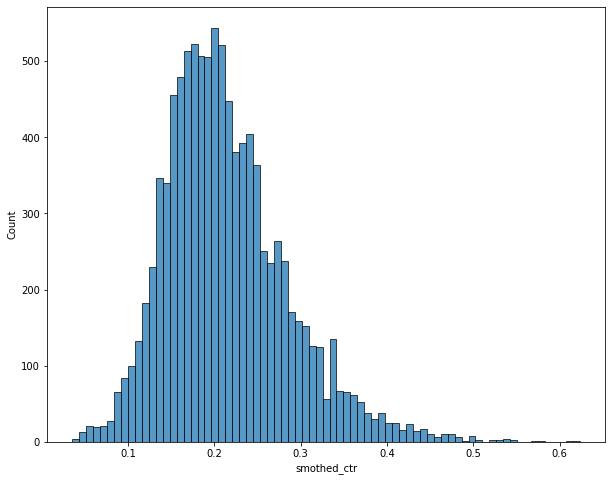

In [14]:
group_1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
plt.figure(figsize=(10, 8))
sns.histplot(group_1.smothed_ctr, 
             kde = False)

Cмотрим на распределение сглаженного CTR для 2 группы:

/tmp/ipykernel_402/959809665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_2['smothed_ctr'] = df.apply(


<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

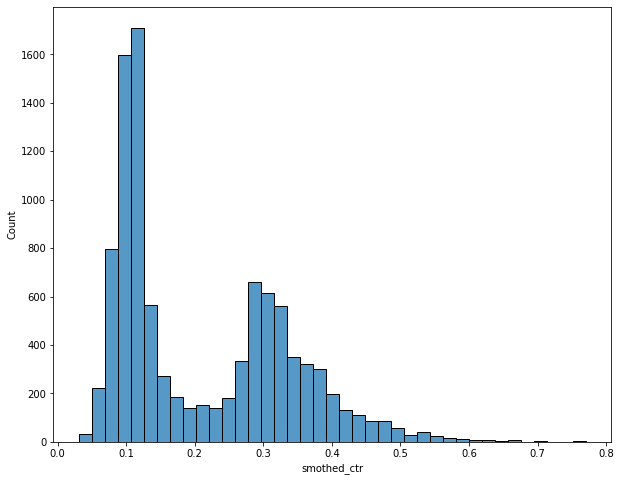

In [15]:
group_2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
plt.figure(figsize=(10, 8))
sns.histplot(group_2.smothed_ctr, 
             kde = False)

#### Т-test для сглаженного CTR

In [16]:
stats.ttest_ind(group_1.smothed_ctr,
                group_2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

#### Тест Манна-Уитни для сглаженного CTR

In [17]:
stats.mannwhitneyu(group_1.smothed_ctr, 
                   group_2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

**Вывод**  
T-test всё равно отрицает различия между группами (но p-value стало меньше), а тест Манна-Уитни допускает значимые различия между группами ещё больше. Однозначного вывода для сглаженного CTR сделать не получается.

### Пуассоновский бутстреп для подсчета разницы в CTR

Идея - мы хотим сравнить общегрупповой CTR в группах A и B. Проблема в том, что это всего лишь два числа. А нам хочется, чтобы это было распределение. Предположим, что наши выборки из групп являются хорошей моделью генеральной совокупности.  

Набираем распределение для разницы в глобальном CTR:

<AxesSubplot:ylabel='Count'>

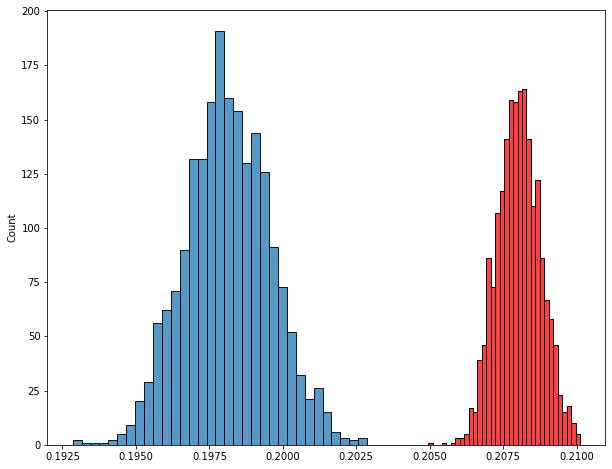

In [18]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2



likes1 = group_1.likes.to_numpy()
views1 = group_1.views.to_numpy()
likes2 = group_2.likes.to_numpy()
views2 = group_2.views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
plt.figure(figsize=(10, 8))
sns.histplot(ctr1, color='red')
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

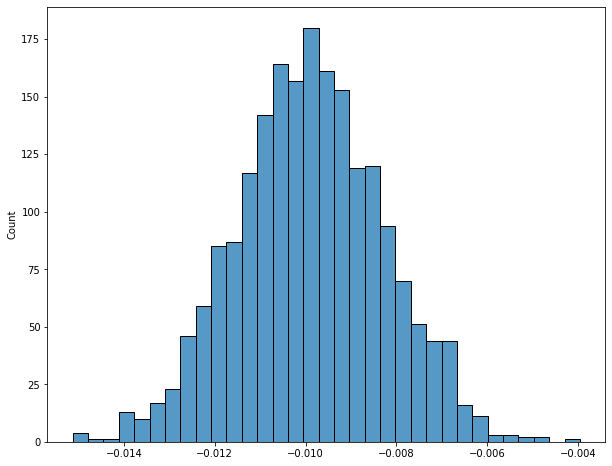

In [19]:
plt.figure(figsize=(10, 8))
sns.histplot(ctr2 - ctr1)

Получилась , что разница между глобальными CTR - отрицательная!

**Вывод**  
Пуассоновский бутстреп показал не только разницу между групповыми CTR, но и то, что 2 группа имеет меньший CTR, чем 1. За счёт достаточного количества пользователей в группах удаётся сформировать репрезентативные подвыборки, глобальные CTR получились по гистограмме приближенными к нормальным и наглядно видна разница между ними.

### Бакетное преобразование

In [20]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-12-02' and '2022-12-08'
        and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

In [21]:
df_bucket.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


**Поверх бакетного преобразования можно, например, применить стандартный t-тест (если примерно выполнены его предположения) или тест Манна-Уитни:**  


Применим Ttest:

In [22]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Здесь T-тест видит отличие.

Применим тест Манна-Уитни:

In [23]:
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

И тест Манна-Уитни тоже видит отличие.

## Выводы

Оценка тестами результатов А/В тестирования показал различные результаты и однозначных выводо сделать нельзя. В связи с чем, эксперимент будем считать неудачным, и в  продакшн такой алгоритм запускать нельзя. 